In [1]:
from ultralytics import YOLO
import math
import cv2


/apps/yolo/v8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cd /blue/eel6825/jovermeyer

/blue/eel6825/jovermeyer


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
def saliencyfunc(img_path, model_path):
    IMG_W = 640
    IMG_H = 512
    # Downloading the model path
    model = YOLO(model_path)
    # Making original model and storing them in an appropriate variable predictions
    orig_results = model.predict(img_path, save=True, save_txt=True)
    classes = orig_results[0].boxes.cls.detach().to('cpu').numpy()
    orig_boxes = orig_results[0].boxes.xyxy.detach().to('cpu').numpy()
    # Gathering information about the image
    image = cv2.imread(img_path)
    np.random.seed(0)
    image_h, image_w = image.shape[:2]
    # List of labels copied from the data.yaml file
    labels = ['person', 'bike', 'car', 'motor', 'airplane', 'bus', 'train', 'truck', 'boat', 'light', 'hydrant', 'sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'deer', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'stroller', 'rider', 'scooter', 'vase', 'scissors', 'face', 'other vehicle', 'license plate']
    # These nested for loops will cycle through each class in the original prediction, and perform prediction on 1000 masked versions of the same image and creating a heatmap based on whether or not the class is detected in the masked images.
    for classy in range(80):
        if classy in classes:
            # Creating blank heat map
            salien = np.zeros((image_h, image_w), dtype=np.float32)
            for x in range(1000):
                # Generating masked images and performing predictions
                mask = generate_mask(image_size=(image_w, image_h), grid_size=(16, 16), prob_thresh=0.5)
                masked = mask_image(image, mask)
                out = model.predict(masked,verbose=False);
                x = out[0].boxes
                res = masked.copy()
                # Determining whether or not the prediction contains the original class and if so adding the masked image to the weighted heatmap
                for box in x:
                    thisclass = box.cls.detach().to('cpu').numpy()
                    confmult = box.conf.detach().to('cpu').numpy()
                    if thisclass != classy:
                        break
                    salien += masked[:,:,0]*confmult
            # Creating a plot for each class from the original image and drawing the original bounding boxes on top of the original heatmaps
            print('Detected Class:',labels[classy])
            fig, ax = plt.subplots()
            sboxes = []
            for x in orig_results[0].boxes:
                x1, y1, x2, y2 = x.xyxy.detach().to('cpu').numpy()[0]
                label = x.cls.detach().to('cpu').numpy()
                if label == classy:
                    sboxes.append([x1,y1,x2,y2])
            ax.imshow(salien)
            for box in sboxes:
                x1, y1, x2, y2 = box
                rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=0.5, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            # Show the plot
            plt.show()

In [6]:
def generate_mask(image_size, grid_size, prob_thresh):
    # This function will generate a random mask based on the input image size
    image_w, image_h = image_size
    grid_w, grid_h = grid_size
    cell_w, cell_h = math.ceil(image_w / grid_w), math.ceil(image_h / grid_h)
    up_w, up_h = (grid_w + 1) * cell_w, (grid_h + 1) * cell_h

    mask = (np.random.uniform(0, 1, size=(grid_h, grid_w)) <
            prob_thresh).astype(np.float32)
    mask = cv2.resize(mask, (up_w, up_h), interpolation=cv2.INTER_LINEAR)
    offset_w = np.random.randint(0, cell_w)
    offset_h = np.random.randint(0, cell_h)
    mask = mask[offset_h:offset_h + image_h, offset_w:offset_w + image_w]
    return mask

In [7]:
def mask_image(image, mask):
    masked = ((image.astype(np.float32) / 255 * np.dstack([mask] * 3)) *
              255).astype(np.uint8)
    return masked

Ultralytics YOLOv8.0.25 🚀 Python-3.8.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA A100-SXM4-80GB, 81251MiB)
Model summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

image 1/1 /blue/eel6825/jovermeyer/conda/envs/yoloenv/bin/datasets/Test/video_thermal_test/data/video-5RSrbWYu9eokv5bvR-frame-000133-CadH7ruusMEg3cDjL.jpg: 512x640 22.4ms
Speed: 3.1ms pre-process, 22.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict9
0 label saved to runs/detect/predict9/labels
Ultralytics YOLOv8.0.25 🚀 Python-3.8.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA A100-SXM4-80GB, 81251MiB)
Model summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

image 1/1 /blue/eel6825/jovermeyer/conda/envs/yoloenv/bin/datasets/Test/video_thermal_test/data/video-ZAtDSNuZZjkZFvMAo-frame-000291-YhKKYKEoAc9fuWBz6.jpg: 512x640 8 persons, 15 cars, 4 lights, 9.8ms
Speed: 0.2ms pre-process, 9.8ms inference, 31.3ms postprocess per image at shape (1,

Detected Class: person


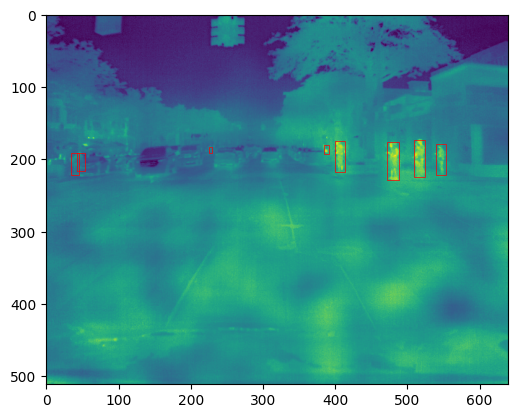

Detected Class: car


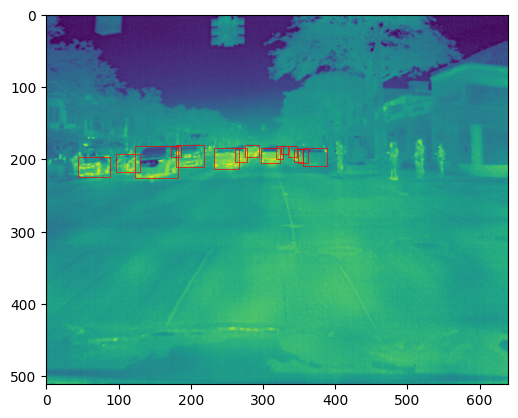

Detected Class: light


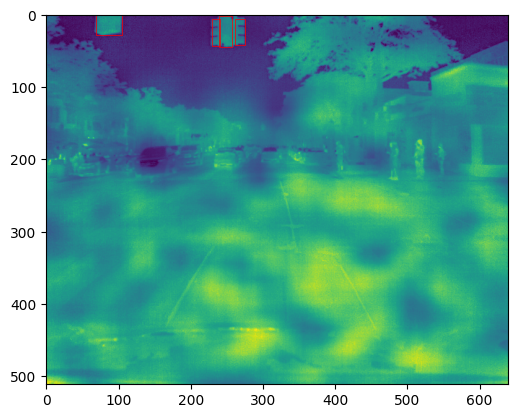

Ultralytics YOLOv8.0.25 🚀 Python-3.8.13 torch-1.13.0+cu117 CUDA:0 (NVIDIA A100-SXM4-80GB, 81251MiB)
Model summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

image 1/1 /blue/eel6825/jovermeyer/conda/envs/yoloenv/bin/datasets/Test/video_thermal_test/data/video-ZAtDSNuZZjkZFvMAo-frame-001239-7qqhLZ4DRcZT2iKur.jpg: 512x640 8 persons, 1 bike, 17 cars, 9.8ms
Speed: 0.2ms pre-process, 9.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict11
1 label saved to runs/detect/predict11/labels


Detected Class: person


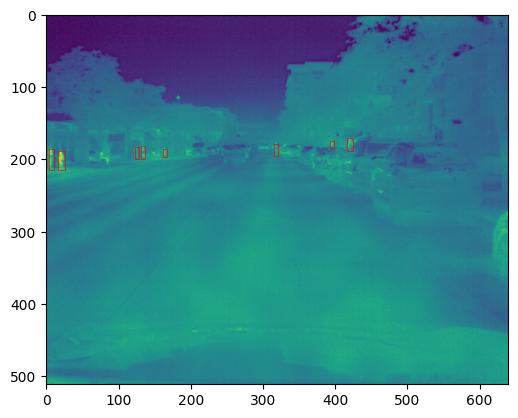

Detected Class: bike


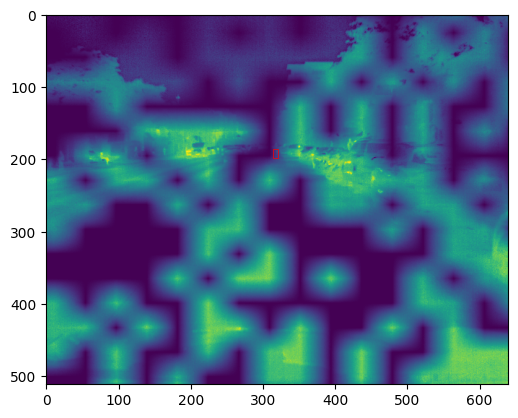

Detected Class: car


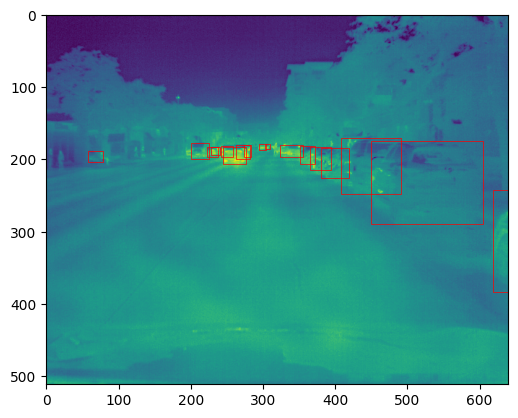

In [8]:
# This call will run the RISE generation algorithm on a few images.
counter = 0
for file in os.listdir('conda/envs/yoloenv/bin/datasets/Test/video_thermal_test/data'):
    counter += 1
    if counter%1000 == 0:
        saliencyfunc('conda/envs/yoloenv/bin/datasets/Test/video_thermal_test/data/'+file, 'runs/detect/Epoch-20 Batch-4 M/weights/best.pt');